# SMU 7331 Data Mining Project 3
##### Authors: Shon Mohsin, Heber Nielsen, Jose Torres, Lokesh Maganti

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pltw
from pandas.plotting import scatter_matrix, parallel_coordinates

from sklearn.metrics import pairwise
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GaussianMixture

import urllib
import re

## Business Understanding: 
#### Requirements: Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

In [107]:
# Data Import from Github
url = 'https://raw.githubusercontent.com/hebernielsen/DS7331_Project3/master/allUsers.lcl.csv' 
df=pd.read_csv(url)
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


Our selected dataset captures hand gestures using Vicon Motion Capture System using a glove with markers, described in detail in the Data Understanding section. The dataset is comprised of 12 users making 5 pre-defined hand gestures below:

1. Fist
2. Stop
3. Point with one finger
4. Point with two fingers
5. Grab

The business problem is to perform cluster analysis on the 5 gestures, regardless of user, to see if discernable patterns can be used to identify the 5 gestures from a combined set where the 12 users are de-identified. 

Our assumption is that the gestures should be similar regardless of the individual user making the gesture. 

## Data Understanding 1:
#### Requirements: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

Our selected dataset captures hand gestures using Vicon Motion Capture System. 

1.The Dataset is the collection,features and organization of motion capture datasets for hand posture and gesture recognition.

2.The purpose of this dataset is to provide the range of motion for each part of the hand/glove to which a marker is attached.

3.Glove constructed to serve as the source of data for all algorithms analysis and development.

4.A glove with fifteen markers attached is used as the source of data for posture and gesture recognition, both for the generation of datasets and for the practical evaluation of developed algorithms.

5.The glove used to capture data along with a sample from each class of posture projected onto the local XY plane. The classes are fist (1), stop (2),point with one finger (3), point with two fingers (4), and grab (5).

6.The data described here is already partially preprocessed in the following manner. The data was transformed and pruned in the same manner as the La-beled Marker Dataset. Any record that could not be transformed or contained fewer than three markers was removed.

7.This dataset may be used for a variety of tasks, the most obvious of which is posture recognition via classication. One may also attempt user identication.Alternatively, one may perform clustering (constrained or unconstrained) to discover marker distributions either as an attempt to predict marker identities or obtain statistical descriptions/visualizations of the postures.

8.Since the pattern is not always visible and has noisy or even incorrect ob-servations, alter should be used to smooth the measurements of the labeled markers.

### Attribute Information:

Data is provided as a CSV file. A header provides the name of each attribute. An initial dummy record composed entirely of 0s should be ignored. A question mark '?' is used to indicate a missing value. A record corresponds to a single instant or frame as recorded by the camera system.

'Class' - Integer. The class ID of the given record. Ranges from 1 to 5 with 1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab). 'User' - Integer. The ID of the user that contributed the record. No meaning other than as an identifier.

Xi - Real. The x-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Yi' - Real. The y-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Zi' - Real. The z-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.
Each record is a set. The i-th marker of a given record does not necessarily
correspond to the i-th marker of a dierent record. One may randomly permute
7
the visible (i.e. not missing) markers of a given record without changing the set
that the record represents. For the sake of convenience, all visible markers of
a given record are given a lower index than any missing marker. A class is not
guaranteed to have even a single record with all markers visible.

### Missing Data and Normalization:

The following preprocessing steps were made to this data:

1) Remove Class 0, which is not a valid Class.
2) Replace '?' values with np.NaN

In [108]:
dropped_indices = df.query('Class==0').index
df = (df
      .drop(labels=dropped_indices, axis=0, errors='ignore')
      .replace(to_replace='?', value=np.nan))

#set data types
df = (pd.concat([df.iloc[:,:2].astype(str), 
                df.iloc[:,2:].astype(np.float64)], axis=1)
      .melt(id_vars=['User', 'Class'])
      .dropna())

In [109]:
df['variable'] = (df['variable'].str
                  .replace('X.*', 'X', regex=True)
                  .replace('Y.*', 'Y', regex=True)
                  .replace('Z.*', 'Z', regex=True))
df['Class'] = df['Class'].map({'1': 'fist', '2': 'stop', 
                               '3': 'pointer', '4': 'pointer_middle', '5': 'grab'})

In [201]:
df.head()

,User,Class,variable,value
0,0,fist,X,54.263880
1,0,fist,X,56.527558
2,0,fist,X,55.849928
3,0,fist,X,55.329647
4,0,fist,X,55.142401


In [110]:
df_adjacent_coords = pd.DataFrame({'User': df.query('variable==\'X\'').reset_index()['User'], 
                                   'Class': df.query('variable==\'X\'').reset_index()['Class'], 
                                   'X': df.query('variable==\'X\'').reset_index()['value'], 
                                   'Y': df.query('variable==\'Y\'').reset_index()['value'],
                                   'Z': df.query('variable==\'Z\'').reset_index()['value']})
df_adjacent_coords.head()

,User,Class,X,Y,Z
0,0,fist,54.263880,71.466776,-64.807709
1,0,fist,56.527558,72.266609,-61.935252
2,0,fist,55.849928,72.469064,-62.562788
3,0,fist,55.329647,71.707275,-63.688956
4,0,fist,55.142401,71.435607,-64.177303


In [ ]:
#pivot not correct
#X, Y, Z needed
#concatenate: X rows, Y rows, Z rows (same shape)


The cell below shifts all sensors according to the average position of the 4 sensors on the back of the hand.

Here is an outline of the normalization process in some more detail:

First, we get the mean position of all 4 origin sensors.  The x-value is stored in `mainsensor_x_mean`.  The y-value in `mainsensor_y_mean`, and the z-value in `mainsensor_z_mean`.  

Repeat for each gesture and user:
+ Loop through all coordinates, shifting x-coordinate by `mainsensor_x_mean`, y-coordinates by `mainsensor_y_mean`, and z_coordinates by `mainsensor_z_mean`.

## Data Understanding 2:
#### Requirements: Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

In [111]:
y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'fist\'')
     .loc[:,['X','Y','Z']]
     .values)

In [204]:
model = DBSCAN(eps=1, min_samples=250).fit(X)

In [205]:
#accuracy
#precision
#recall
#F-score

#n_clusters = 2
#model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)


labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(data, labels))

# silhouette_per_sample = metrics.silhouette_samples(data,labels)

# # get the middle of each cluster
# centroids = []
# for lab in range(0,n_clusters_):
#     centroids.append( [np.mean(data[np.where(labels==lab),0]), np.mean(data[np.where(labels==lab),1])] )
# centroids = np.array(centroids)

# plt.figure()
# plt.scatter(data[:, 0], data[:, 1], c=labels,
#                     cmap=plt.cm.spectral, s=5, linewidths=0)

# if len(centroids)>0:
#     plt.scatter(centroids[:, 0], centroids[:, 1],
#                 marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
# plt.title('Estimated number of clusters: %d' % n_clusters_)

# plt.figure()
# plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
#                 cmap=plt.cm.gray, s=5, linewidths=0)
# plt.title('Clusters with silhouette coefficient coloring')
# plt.show()

Estimated number of clusters: 23


In [206]:
pd.Series(labels).value_counts()

-1     71759
 15     1590
 16     1526
 17     1478
 18     1424
 2      1234
 11     1228
 13     1001
 20      945
 12      933
 19      891
 0       870
 21      818
 10      645
 6       580
 7       547
 1       488
 14      462
 9       432
 3       393
 5       371
 22      353
 4       337
 8       310
dtype: int64

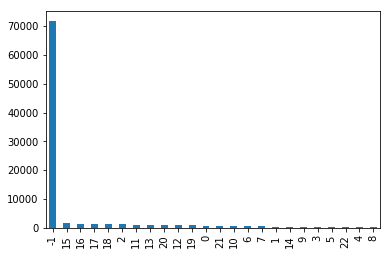

In [207]:
pd.Series(labels).value_counts().plot(kind='bar')

In [20]:
#clustering code


#import, clean, and preprocess data before defining X1
clf = KMeans(n_clusters=5, init='k-means++',random_state=1)
clf.fit(X)
fitted_labels = clf.labels_ # the labels from kmeans clustering

acc = cross_val_score(clf,X,y=y)

print ("Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100)

/home/jat055000_gmail_com/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Average accuracy (with kmeans for class/fare)=  -87245422877.50835 +- 5585893417.278383


Initial Test
1. Select all fist gesture points for all users
2. 

## Modeling and Evaluation 1:
#### Requirements: Train and adjust parameters

## Modeling and Evaluation 1:
#### Requirements: Evaluate and Compare

## Modeling and Evaluation 3:
#### Requirements: Visualize Results

## Modeling and Evaluation 4:
#### Requirements: Summarize the Remifications

## Deployment:
#### Requirements: Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
##### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
##### How would your deploy your model for interested parties?
##### What other data should be collected? 
#####  How often would the model need to be updated, etc.?

### Exceptional Work:
#### Requirements: You have free reign to provide additional analyses or combine analyses.

### (FROM HERE ONWARDS, THESE ARE SECTIONS WE MIGHT USE AS SUBSECTIONS WITHIN THE MAIN SECTIONS ABOVE.
##### -Heber)

## Evaluation:

## Data Preparation:

#### Data Meaning Type:

## Data Quality:

### Missing Values:

### Outliers:

## Data Visualization and Visual Analysis:

## Summary Statistics and Commentary:

### Main Observations: